In [1]:
import pandas as pd
import os
import numpy as np

import sys
import subprocess

import re
from sklearn.model_selection import train_test_split
from typing import Tuple, Dict, List, Any
from geopy.distance import great_circle

##Para modelar
from lightgbm import LGBMClassifier, early_stopping
from xgboost import XGBClassifier, callback
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import (
    precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, precision_recall_curve
)
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone # Importante para clonar modelos en CV

from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline


# ── imports ──────────────────────────────────────────────────────────────────
from __future__ import annotations
import subprocess
from typing import Any, Dict, List, Tuple

import numpy as np
import pandas as pd
from sklearn.base import clone
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, precision_recall_curve
)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedRandomForestClassifier

from lightgbm import LGBMClassifier, early_stopping
from xgboost import XGBClassifier, callback
# Ocultar advertencias
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)


project_root = os.path.dirname(((os.getcwd())))
scripts_dir = os.path.join(project_root,"src", "scripts")
raw_data_inei = os.path.join(project_root,"data", "01_raw", "inei")
sys.path.insert(0, scripts_dir)

from getting_modules import EndesProcessor
from merging_data import JoinProcessor

In [2]:
df_ubigeo= pd.read_csv(raw_data_inei+"\\geo\\ubigeo_provincia.csv",dtype={'inei':str})
df_ubigeo=df_ubigeo[['inei', 'departamento',   'macroregion_inei', 'pob_densidad_2020',  'latitude',
       'longitude', 'indice_densidad_estado',
       'indice_vulnerabilidad_alimentaria', 'idh_2019', 'pct_pobreza_total',
       'pct_pobreza_extrema']]
df_ubigeo.rename(columns={'inei':'ubigeo_prov'}, inplace=True)

In [3]:
df_ubigeo.head()

,ubigeo_prov,departamento,macroregion_inei,pob_densidad_2020,latitude,longitude,indice_densidad_estado,indice_vulnerabilidad_alimentaria,idh_2019,pct_pobreza_total,pct_pobreza_extrema
0,010100,AMAZONAS,ORIENTE,17.743489,-6.229444,-77.872778,0.767279,0.396175,0.542665,22.021474,11.698524
1,010200,AMAZONAS,ORIENTE,17.356246,-5.638889,-78.531111,0.649203,0.519479,0.461036,34.843027,23.068140
2,010300,AMAZONAS,ORIENTE,10.222501,-5.904444,-77.797778,0.716391,0.509355,0.412895,33.240504,10.740246
3,010400,AMAZONAS,ORIENTE,4.221772,-4.592222,-77.864444,0.408829,0.690789,0.253452,56.831603,38.140629
4,010500,AMAZONAS,ORIENTE,15.703437,-6.139167,-77.952222,0.705204,0.582215,0.341050,48.148547,24.997884


In [4]:
def calcular_distancia(row):
    """
    Calcula la distancia great-circle en km y DEVUELVE UN ÚNICO NÚMERO.
    """
    try:
        # Define los puntos con formato (latitud, longitud)
        punto_origen = (row['latitud'], row['longitud'])
        punto_capital = (row['latitude'], row['longitude'])

        # La sentencia 'return' DEBE devolver un único valor numérico
        return great_circle(punto_origen, punto_capital).km
    
    except Exception as e:
        # Es buena práctica devolver un valor nulo si hay un error en una fila
        # para no detener todo el proceso.
        print(f"Error en una fila: {e}")



In [5]:


rutas_modulos_23 = [
    "910-Modulo1629",
    "910-Modulo1630",
    "910-Modulo1631",
    "910-Modulo1632",
    "910-Modulo1633",
    "910-Modulo1634",
    "910-Modulo1635",
    "910-Modulo1636",
    "910-Modulo1637",
    "910-Modulo1638",
    "910-Modulo1639",
    "910-Modulo1640",
    "910-Modulo1641",
]

rutas_modulos_24 = [
    "968-Modulo1629",
    "968-Modulo1630",
    "968-Modulo1631",
    "968-Modulo1632",
    "968-Modulo1633",
    "968-Modulo1634",
    "968-Modulo1635",
    "968-Modulo1636",
    "968-Modulo1637",
    "968-Modulo1638",
    "968-Modulo1639",
    "968-Modulo1640",
    "968-Modulo1641",
]



path_23= raw_data_inei+f"\\2023"
path_24= raw_data_inei+f"\\2024"


processor_23 = EndesProcessor(data_path=path_23, anio=2023)
processor_24 = EndesProcessor(data_path=path_24, anio=2024)


dfs_procesados_23 = {
    f"mod_{i+1}": getattr(processor_23, f"procesar_modulo_{i+1}")(
        os.path.join(path_23, rutas_modulos_23[i]),
        2023
    )
    for i in range(len(rutas_modulos_23))
}

dfs_procesados_24 = {
    f"mod_{i+1}": getattr(processor_24, f"procesar_modulo_{i+1}")(
        os.path.join(path_24, rutas_modulos_24[i]),
        2024
    )
    for i in range(len(rutas_modulos_23))
}


Iniciando el procesamiento del Módulo 1 (RECH0, RECH1, RECH4) para el año 2023...


e:\Python\UTEC\Fundamentos\low-birth-weight-alert\src\scripts\getting_modules.py:65: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_hogar = df_hogar.applymap(lambda x: x.strip() if isinstance(x, str) else x)
e:\Python\UTEC\Fundamentos\low-birth-weight-alert\src\scripts\getting_modules.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_miembros = df_miembros.applymap(lambda x: x.strip() if isinstance(x, str) else x)


Advertencia: No se pudo procesar RECH4. Razón: Usecols do not match columns, columns expected but not found: ['HHO']. Se continuará sin datos de seguros.
Uniendo dataframes del Módulo 1...
Proceso del Módulo 1 completado. DataFrame con 139278 filas y 15 columnas.
Iniciando el procesamiento del Módulo 2 (RECH23) para el año 2023...
Cargando e:\Python\UTEC\Fundamentos\low-birth-weight-alert\data\01_raw\inei\2023\910-Modulo1630\RECH23_2023.csv...


e:\Python\UTEC\Fundamentos\low-birth-weight-alert\src\scripts\getting_modules.py:175: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_hogar_caracteristicas = df_hogar_caracteristicas.applymap(lambda x: x.strip() if isinstance(x, str) else x)


Proceso del Módulo 2 completado. DataFrame con 37486 filas y 16 columnas.
Iniciando el procesamiento del Módulo 3 (REC0111, REC91) para el año 2023...
Uniendo dataframes del Módulo 3...
Proceso del Módulo 3 completado. DataFrame con 38352 filas y 13 columnas.
Iniciando el reprocesamiento del Módulo 4 (RE223132, REC21) para el año 2023...
Uniendo dataframes del Módulo 4...
Proceso del Módulo 4 completado. DataFrame con 63593 filas y 11 columnas.
Iniciando el reprocesamiento del Módulo 5 (REC41, REC94) para el año 2023...
Módulo 5 reprocesado. DataFrame con 20840 filas y 12 columnas.
Iniciando el reprocesamiento del Módulo 6 para el año 2023...
Módulo 6 reprocesado. DataFrame con 23316 filas y 19 columnas.
Iniciando el procesamiento del Módulo 7 (RE516171) para el año 2023...
Cargando e:\Python\UTEC\Fundamentos\low-birth-weight-alert\data\01_raw\inei\2023\910-Modulo1635\RE516171_2023.csv...
Módulo 7 procesado. DataFrame con 35657 filas y 11 columnas.
Iniciando el procesamiento final del 

e:\Python\UTEC\Fundamentos\low-birth-weight-alert\src\scripts\getting_modules.py:65: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_hogar = df_hogar.applymap(lambda x: x.strip() if isinstance(x, str) else x)
e:\Python\UTEC\Fundamentos\low-birth-weight-alert\src\scripts\getting_modules.py:74: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_miembros = df_miembros.applymap(lambda x: x.strip() if isinstance(x, str) else x)


Advertencia: No se pudo procesar RECH4. Razón: Usecols do not match columns, columns expected but not found: ['HHO']. Se continuará sin datos de seguros.
Uniendo dataframes del Módulo 1...
Proceso del Módulo 1 completado. DataFrame con 135045 filas y 15 columnas.
Iniciando el procesamiento del Módulo 2 (RECH23) para el año 2024...
Cargando e:\Python\UTEC\Fundamentos\low-birth-weight-alert\data\01_raw\inei\2024\968-Modulo1630\RECH23_2024.csv...


e:\Python\UTEC\Fundamentos\low-birth-weight-alert\src\scripts\getting_modules.py:175: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_hogar_caracteristicas = df_hogar_caracteristicas.applymap(lambda x: x.strip() if isinstance(x, str) else x)


Proceso del Módulo 2 completado. DataFrame con 37390 filas y 16 columnas.
Iniciando el procesamiento del Módulo 3 (REC0111, REC91) para el año 2024...
Uniendo dataframes del Módulo 3...
Proceso del Módulo 3 completado. DataFrame con 37117 filas y 13 columnas.
Iniciando el reprocesamiento del Módulo 4 (RE223132, REC21) para el año 2024...
Uniendo dataframes del Módulo 4...
Proceso del Módulo 4 completado. DataFrame con 60693 filas y 11 columnas.
Iniciando el reprocesamiento del Módulo 5 (REC41, REC94) para el año 2024...
Módulo 5 reprocesado. DataFrame con 19751 filas y 12 columnas.
Iniciando el reprocesamiento del Módulo 6 para el año 2024...
Módulo 6 reprocesado. DataFrame con 21999 filas y 19 columnas.
Iniciando el procesamiento del Módulo 7 (RE516171) para el año 2024...
Cargando e:\Python\UTEC\Fundamentos\low-birth-weight-alert\data\01_raw\inei\2024\968-Modulo1635\RE516171_2024.csv...
Módulo 7 procesado. DataFrame con 34252 filas y 11 columnas.
Iniciando el procesamiento final del 

In [6]:

join_processor_23= JoinProcessor(dfs_procesados_23, '2023')
join_processor_24= JoinProcessor(dfs_procesados_24, '2024')

df_master= pd.concat([join_processor_24.combinar_modulos(dfs_procesados_24, '2024'),
                      join_processor_23.combinar_modulos(dfs_procesados_23, '2023')
                      ],ignore_index=True)


print("shape antes de eliminar duplicados: ",df_master.shape )
id_cols = {
"id_hogar", "id_miembro_hogar", "id_cuestionario_mujer",
"id_nacimiento", "id_miembro_hogar", "ubigeo","anio","latitud","longitud"
}
# Nos aseguramos de que existan en el DF
id_cols = [c for c in id_cols if c in df_master.columns]

df_sin_ids = df_master.drop(columns=id_cols, errors="ignore")
df_master = df_master.loc[~df_sin_ids.duplicated(keep="first")].reset_index(drop=True)
df_master['ubigeo_prov'] = df_master['ubigeo'].astype(str).str[:-2] + '00'
df_master= df_master.merge(df_ubigeo, how='inner', on='ubigeo_prov')

df_master.drop(columns='ubigeo_prov', inplace=True)
df_master['distance_km_capital_province'] = df_master.apply(calcular_distancia, axis=1)

print("shape después  de eliminar duplicados: ",df_master.shape )

Uniendo con datos de características del hogar (Módulo 2)...
Traduciendo códigos a valores descriptivos...
Uniendo con datos prenatales y de parto (Módulo 5)...

Unión con Módulo 5 y mapeo completados.
shape antes de eliminar duplicados:  (19751, 92)
shape después  de eliminar duplicados:  (19751, 92)
Uniendo con datos de características del hogar (Módulo 2)...
Traduciendo códigos a valores descriptivos...
Uniendo con datos prenatales y de parto (Módulo 5)...

Unión con Módulo 5 y mapeo completados.
shape antes de eliminar duplicados:  (20840, 92)
shape después  de eliminar duplicados:  (20840, 92)
shape antes de eliminar duplicados:  (40591, 92)
shape después  de eliminar duplicados:  (40591, 103)


In [7]:
df_master.head()

,id_cuestionario_mujer,id_nacimiento,sexo_bebe,bebe_esta_vivo,intervalo_nacimiento_anterior_meses,id_miembro_hogar,total_hijos_nacidos,edad_mujer_primer_parto,mujer_actualmente_embarazada,mujer_uso_anticonceptivo_alguna_vez,...,macroregion_inei,pob_densidad_2020,latitude,longitude,indice_densidad_estado,indice_vulnerabilidad_alimentaria,idh_2019,pct_pobreza_total,pct_pobreza_extrema,distance_km_capital_province
0,325503101 2,1,2,1,60,3,3,22,0,3,...,ORIENTE,17.743489,-6.229444,-77.872778,0.767279,0.396175,0.542665,22.021474,11.698524,1.330599
1,325504701 2,1,2,1,130,4,2,20,0,3,...,ORIENTE,17.743489,-6.229444,-77.872778,0.767279,0.396175,0.542665,22.021474,11.698524,1.330599
2,325505001 1,1,2,1,216,3,2,17,0,3,...,ORIENTE,17.743489,-6.229444,-77.872778,0.767279,0.396175,0.542665,22.021474,11.698524,1.330599
3,325508901 2,1,2,1,147,4,2,21,0,3,...,ORIENTE,17.743489,-6.229444,-77.872778,0.767279,0.396175,0.542665,22.021474,11.698524,1.330599
4,325509701 2,1,1,1,96,4,2,21,0,3,...,ORIENTE,17.743489,-6.229444,-77.872778,0.767279,0.396175,0.542665,22.021474,11.698524,1.330599


In [8]:
POST_BIRTH_PATTERNS: List[str] = [
    r'^bebe_', r'^edad_nino', r'^educacion_nino', r'^vacuna_',
     r'_bebe$', r'^dieta_nino', r'^dx_anemia_bebe',
     r'_cred$', r'_jarabe_', 
    r'complicacion_','lugar_parto','parto_fue_cesarea',"consumio_micronutrientes_ult_7_dias",
    'tuvo_diarrea_ult_2_semanas', 'tuvo_fiebre_ult_2_semanas',
       'tuvo_tos_ult_2_semanas','tomo_suplemento_hierro', 'hogar_beneficiario_beca18',
       "mujer_actualmente_embarazada"
]

def preparar_datos_bajo_peso(
    df: pd.DataFrame,
    test_size: float = 0.30,
    random_state: int = 42
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.Series, pd.Series]:

    df = df.copy()

    # PASO 0: AISLAR LOS IDs PARA PROTEGERLOS DE TRANSFORMACIONES
    id_cols_a_preservar = [
        "id_hogar", "id_miembro_hogar", "id_cuestionario_mujer", "id_nacimiento"
    ]
    # Nos aseguramos de que las columnas existan en el DataFrame
    id_cols_a_preservar = [col for col in id_cols_a_preservar if col in df.columns]
    
    # Guardamos los IDs originales en un DataFrame separado
    df_ids = df[id_cols_a_preservar].copy()
    
    # Creamos un DataFrame de trabajo solo con las columnas a procesar
    df_procesar = df.drop(columns=id_cols_a_preservar, errors="ignore")

    # ───────── 1) Imputación (aplicada solo a df_procesar) ──────────
    for col in df_procesar.columns:
        serie = df_procesar[col]
        n_unique = serie.dropna().nunique()
        es_categ = (serie.dtype == "object") or (n_unique <= 9)

        if es_categ:
            modo = serie.mode(dropna=True)
            relleno = modo.iloc[0] if not modo.empty else 0
            df_procesar[col] = serie.fillna(relleno)
        else:
            mediana = serie.median(skipna=True)
            relleno = mediana if not np.isnan(mediana) else 0
            df_procesar[col] = serie.fillna(relleno)

    # ───────── 2) Codificación de texto (aplicada solo a df_procesar) ──
    for col in df_procesar.select_dtypes(include=['object']).columns:
        s = df_procesar[col].astype(str).str.lower().str.strip()
        uniques = [u for u in s.unique() if u != 'nan']

        if set(uniques) <= {'si', 'sí', 'no', '0', '1'}:
            df_procesar[col] = s.map({'si': 1, 'sí': 1, 'no': 0, '1': 1, '0': 0}).astype(int)
        elif len(uniques) == 2:
            mapping = {val: idx for idx, val in enumerate(uniques)}
            df_procesar[col] = s.map(mapping).astype(int)
        else:
            df_procesar[col] = pd.Categorical(s).codes

    # ───────── 3) Variable objetivo bajo_peso ───────────────────────
    umbral = np.where(df_procesar['sexo_bebe'] == 1, 2500, 2400)
    df_procesar['bajo_peso'] = (df_procesar['peso_bebe_nacimiento_gr'] < umbral).astype(int)

    # ───────── 4) Quitar columnas post-nacimiento ───────────────────
    cols_a_eliminar = {
        c for patron in POST_BIRTH_PATTERNS
        for c in df_procesar.columns if re.search(patron, c)
    }
    df_procesar.drop(columns=cols_a_eliminar & set(df_procesar.columns), inplace=True)

    # PASO 5: RECOMBINAR IDs ORIGINALES CON DATOS PROCESADOS
    df_final = pd.concat([df_ids, df_procesar], axis=1)

    # ───────── 6) Split estratificado y eliminación de duplicados ────
    df_final['estrato'] = df_final['anio'].astype(str) + '_' + df_final['bajo_peso'].astype(str)
    
    print("Shape antes de eliminar duplicados:", df_final.shape)
    
    # Para la deduplicación, usamos todas las columnas EXCEPTO los IDs que preservamos
    cols_para_deduplicar = [col for col in df_final.columns if col not in id_cols_a_preservar]
    df_final = df_final.loc[~df_final[cols_para_deduplicar].duplicated(keep="first")].reset_index(drop=True)
    
    print("Shape después de eliminar duplicados:", df_final.shape)

    # `X` contendrá las características procesadas Y los IDs originales
    X = df_final.drop(columns=['bajo_peso', 'estrato'])
    y = df_final['bajo_peso']
    strat = df_final['estrato']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=strat
    )

    return X_train, X_test, y_train, y_test

In [9]:
# df_master es tu DataFrame original
X_train, X_test, y_train, y_test = preparar_datos_bajo_peso(df_master)

# Verifica tamaños y proporciones
print(X_train.shape, X_test.shape)
print(y_train.value_counts(normalize=True), y_test.value_counts(normalize=True))
print(X_train['anio'].value_counts(normalize=True))
print(X_test['anio'].value_counts(normalize=True))


C:\Users\Usuario\AppData\Local\Temp\ipykernel_22488\3528085818.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_procesar[col] = serie.fillna(relleno)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_22488\3528085818.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_procesar[col] = serie.fillna(relleno)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_22488\3528085818.py:41: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To o

Shape antes de eliminar duplicados: (40591, 84)
Shape después de eliminar duplicados: (40590, 84)
(28413, 82) (12177, 82)
bajo_peso
0    0.940027
1    0.059973
Name: proportion, dtype: float64 bajo_peso
0    0.940051
1    0.059949
Name: proportion, dtype: float64
anio
1    0.513427
0    0.486573
Name: proportion, dtype: float64
anio
1    0.513427
0    0.486573
Name: proportion, dtype: float64


In [10]:
# ─────────────────────────────────────────────────────────────────────────────
# train_bajo_peso.py
# Entrena varios modelos y selecciona el mejor según AUC-PR / AUC-ROC.
# Pensado para ~25 k filas y clases desbalanceadas.
# ─────────────────────────────────────────────────────────────────────────────
from __future__ import annotations

import logging
import subprocess
from pathlib import Path
from typing import Any, Dict, List, Tuple

import numpy as np
import pandas as pd
from sklearn.base import clone
from sklearn.metrics import (
    average_precision_score,
    confusion_matrix,
    f1_score,
    matthews_corrcoef,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

from lightgbm import LGBMClassifier, early_stopping
from xgboost import XGBClassifier, callback
from sklearn.linear_model import LogisticRegression

# ── logging ──────────────────────────────────────────────────────────────────
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s  %(levelname)s  %(message)s",
    datefmt="%H:%M:%S",
)

# ── utilidades ───────────────────────────────────────────────────────────────
def _gpu_available() -> bool:
    """Devuelve True si hay GPU NVIDIA visible por `nvidia-smi`."""
    try:
        rc = subprocess.run(
            ["nvidia-smi", "-L"],
            stdout=subprocess.DEVNULL,
            stderr=subprocess.DEVNULL,
            check=False,
        ).returncode
        return rc == 0
    except FileNotFoundError:
        return False


def _basic_metrics(
    y: np.ndarray, y_hat: np.ndarray, y_prob: np.ndarray
) -> Dict[str, float]:
    """Precision, Recall, Specificity, F1, ROC-AUC, PR-AUC, MCC."""
    tn, fp, fn, tp = confusion_matrix(y, y_hat).ravel()
    spec = tn / (tn + fp) if tn + fp else 0.0
    try:
        auc_roc = roc_auc_score(y, y_prob)
        auc_pr = average_precision_score(y, y_prob)
    except ValueError:
        auc_roc, auc_pr = np.nan, np.nan
    return {
        "Precision": precision_score(y, y_hat, zero_division=0),
        "Recall": recall_score(y, y_hat, zero_division=0),
        "Specificity": spec,
        "F1": f1_score(y, y_hat, zero_division=0),
        "AUC_ROC": auc_roc,
        "AUC_PR": auc_pr,
        "MCC": matthews_corrcoef(y, y_hat),
    }


def _select_threshold(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    metric: str = "f1",
) -> float:
    """Devuelve el umbral que maximiza F1, recall o precision."""
    metric = metric.lower()
    prec, rec, thr = precision_recall_curve(y_true, y_prob)
    f1 = np.where(prec + rec, 2 * prec * rec / (prec + rec), 0)

    metric_map = {"f1": f1, "recall": rec, "precision": prec}
    if metric not in metric_map:
        raise ValueError(f"metric debe ser one of {list(metric_map)}")
    idx = int(np.argmax(metric_map[metric]))
    return float(thr[idx]) if idx < len(thr) else 0.5


# ── función principal ────────────────────────────────────────────────────────
def train_bajo_peso(
    X: pd.DataFrame,
    y: pd.Series,
    *,
    drop_cols: List[str] | None = None,
    random_state: int = 42,
    smote: bool = False,
    threshold_metric: str = "f1",
) -> Tuple[Any, float, pd.DataFrame]:
    """
    Entrena Balanced RF, LightGBM, XGBoost y Regresión Logística L1.
    Retorna: modelo entrenado, umbral óptimo y tabla de métricas CV.
    """
    drop_cols = drop_cols or []
    X = X.drop(columns=[c for c in drop_cols if c in X], errors="ignore")

    # Relación clases → scale_pos_weight
    pos = int(y.sum())
    neg = len(y) - pos
    ratio = neg / max(pos, 1)
    scale_pos_weight = np.sqrt(ratio)  # suavizado continuo

    logging.info("pos=%d  neg=%d  scale_pos_weight=%.2f", pos, neg, scale_pos_weight)

    use_gpu = _gpu_available()
    logging.info("GPU NVIDIA detectada: %s", use_gpu)

    # Resampling
    smt = SMOTETomek(sampling_strategy=0.2, random_state=random_state, n_jobs=-1)
    sampler_step = ("smt", smt) if smote else None

    # ---------- Definición de modelos ----------
    def make_lgbm(**extra):
        return LGBMClassifier(
            objective="binary",
            device_type="gpu" if use_gpu else "cpu",
            n_estimators=300,
            learning_rate=0.1,
            num_leaves=24,
            min_child_samples=60,
            subsample=0.8,
            colsample_bytree=0.8,
            lambda_l1=0.0,
            lambda_l2=10.0,
            scale_pos_weight=scale_pos_weight,
            random_state=random_state,
            n_jobs=-1,
            **extra,
        )

    def make_xgb(**extra):
        return XGBClassifier(
            eval_metric="aucpr",
            objective="binary:logistic",
            tree_method="gpu_hist" if use_gpu else "hist",
            predictor="gpu_predictor" if use_gpu else "auto",
            n_estimators=300,
            learning_rate=0.1,
            max_depth=5,
            min_child_weight=6,
            subsample=0.8,
            colsample_bytree=0.8,
            gamma=0,
            alpha=0.0,
            reg_lambda=10.0,
            scale_pos_weight=scale_pos_weight,
            random_state=random_state,
            n_jobs=-1,
            **extra,
        )

    modelos: dict[str, ImbPipeline] = {
        "Balanced RF": ImbPipeline(
            steps=[
                *([sampler_step] if sampler_step else []),
                (
                    "clf",
                    BalancedRandomForestClassifier(
                        n_estimators=600,
                        max_depth=8,
                        min_samples_leaf=5,
                        bootstrap=False,
                        random_state=random_state,
                        n_jobs=-1,
                    ),
                ),
            ]
        ),
        "LightGBM": ImbPipeline(
            steps=[
                *([sampler_step] if sampler_step else []),
                ("clf", make_lgbm()),
            ]
        ),
        "XGBoost": ImbPipeline(
            steps=[
                *([sampler_step] if sampler_step else []),
                ("clf", make_xgb()),
            ]
        ),
        "Regresión Logística": ImbPipeline(
            steps=[
                *([sampler_step] if sampler_step else []),
                ("sc", StandardScaler(with_mean=False)),
                (
                    "clf",
                    LogisticRegression(
                        solver="saga",
                        penalty="l1",
                        C=0.1,
                        max_iter=6000,
                        class_weight="balanced",
                        random_state=random_state,
                        n_jobs=-1,
                    ),
                ),
            ]
        ),
    }

    # ---------- Cross-validation ----------
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    cv_results: Dict[str, list[Dict[str, float]]] = {n: [] for n in modelos}
    thresholds: Dict[str, list[float]] = {n: [] for n in modelos}

    logging.info("Iniciando validación cruzada 5-fold…")
    for nombre, pipe_tpl in modelos.items():
        logging.info("• Modelo: %s", nombre)
        for tr_idx, val_idx in skf.split(X, y):
            X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
            y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

            pipe = clone(pipe_tpl)

            # Callbacks de early stopping
            if nombre == "LightGBM":
                pipe.fit(
                    X_tr,
                    y_tr,
                    clf__eval_set=[(X_val, y_val)],
                    clf__eval_metric="aucpr",
                    clf__callbacks=[early_stopping(50, verbose=False)],
                )
            elif nombre == "XGBoost":
                pipe.set_params(
                    clf__callbacks=[callback.EarlyStopping(rounds=50, metric_name="aucpr")]
                )
                pipe.fit(
                    X_tr,
                    y_tr,
                    clf__eval_set=[(X_val, y_val)],
                    clf__verbose=False,
                )
            else:
                pipe.fit(X_tr, y_tr)

            y_prob = pipe.predict_proba(X_val)[:, 1]
            thr = _select_threshold(y_val.to_numpy(), y_prob, threshold_metric)
            y_hat = (y_prob >= thr).astype(int)

            cv_results[nombre].append(_basic_metrics(y_val, y_hat, y_prob))
            thresholds[nombre].append(thr)

    # ---------- Consolidar métricas ----------
    metrics_df = (
        pd.concat({k: pd.DataFrame(v) for k, v in cv_results.items()})
        .groupby(level=0)
        .mean()
        .reset_index()
        .rename(columns={"index": "modelo"})
    )

    percent_cols = ["Precision", "Recall", "Specificity", "F1", "AUC_ROC", "AUC_PR"]
    metrics_df[percent_cols] = metrics_df[percent_cols].applymap(
        lambda x: f"{x*100:.2f}%"
    )

    # Modelo ganador por AUC-PR
    best_model_name = (
        metrics_df.assign(
            pr=lambda d: d["AUC_PR"].str.rstrip("%").astype(float)
        ).sort_values("pr", ascending=False)
        .iloc[0]["modelo"]
    )
    logging.info("Mejor modelo según AUC-PR: %s", best_model_name)

    # ---------- Re-entrenar con todo el conjunto ----------
    best_pipe = clone(modelos[best_model_name])
    if hasattr(best_pipe.named_steps["clf"], "set_params"):
        best_pipe.set_params(clf__callbacks=None)
    best_pipe.fit(X, y)

    best_thresh = float(np.mean(thresholds[best_model_name]))
    logging.info("Umbral final óptimo (promedio CV): %.4f", best_thresh)

    return best_pipe, best_thresh, metrics_df


In [11]:
from __future__ import annotations

import logging
import subprocess
from pathlib import Path
from typing import Any, Dict, List, Tuple

import numpy as np
import pandas as pd
from sklearn.base import clone
from sklearn.metrics import (
    average_precision_score,
    confusion_matrix,
    f1_score,
    matthews_corrcoef,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_auc_score,
)
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.pipeline import Pipeline as ImbPipeline

from lightgbm import LGBMClassifier, early_stopping
from xgboost import XGBClassifier, callback

# ── logging ──────────────────────────────────────────────────────────────────
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s  %(levelname)s  %(message)s",
    datefmt="%H:%M:%S",
)

# ── utilidades ───────────────────────────────────────────────────────────────
def _gpu_available() -> bool:
    """True si `nvidia-smi` detecta una GPU NVIDIA."""
    try:
        return (
            subprocess.run(
                ["nvidia-smi", "-L"],
                stdout=subprocess.DEVNULL,
                stderr=subprocess.DEVNULL,
                check=False,
            ).returncode
            == 0
        )
    except FileNotFoundError:
        return False


def _basic_metrics(
    y: np.ndarray, y_hat: np.ndarray, y_prob: np.ndarray
) -> Dict[str, float]:
    """Precision, Recall, Specificity, F1, ROC-AUC, PR-AUC, MCC."""
    tn, fp, fn, tp = confusion_matrix(y, y_hat).ravel()
    spec = tn / (tn + fp) if tn + fp else 0.0
    try:
        auc_roc = roc_auc_score(y, y_prob)
        auc_pr = average_precision_score(y, y_prob)
    except ValueError:  # ocurre si un fold no contiene ambas clases
        auc_roc = auc_pr = np.nan
    return {
        "Precision": precision_score(y, y_hat, zero_division=0),
        "Recall": recall_score(y, y_hat, zero_division=0),
        "Specificity": spec,
        "F1": f1_score(y, y_hat, zero_division=0),
        "AUC_ROC": auc_roc,
        "AUC_PR": auc_pr,
        "MCC": matthews_corrcoef(y, y_hat),
    }


def _select_threshold(
    y_true: np.ndarray,
    y_prob: np.ndarray,
    metric: str = "f1",
) -> float:
    """Umbral que maximiza F1, recall o precision (según `metric`)."""
    prec, rec, thr = precision_recall_curve(y_true, y_prob)
    with np.errstate(divide="ignore", invalid="ignore"):
        f1 = np.where(prec + rec, 2 * prec * rec / (prec + rec), 0)

    metric_map = {"f1": f1, "recall": rec, "precision": prec}
    metric = metric.lower()
    if metric not in metric_map:
        raise ValueError(f"metric debe ser {list(metric_map)}")
    idx = int(np.argmax(metric_map[metric]))
    return float(thr[idx]) if idx < len(thr) else 0.5


# ── función principal ────────────────────────────────────────────────────────
def train_bajo_peso(
    X: pd.DataFrame,
    y: pd.Series,
    *,
    drop_cols: List[str] | None = None,
    random_state: int = 42,
    smote: bool = False,
    threshold_metric: str = "f1",
) -> Tuple[Any, float, pd.DataFrame]:
    """Entrena 4 modelos y devuelve el mejor por AUC-PR."""
    drop_cols = drop_cols or []
    X = X.drop(columns=[c for c in drop_cols if c in X], errors="ignore")

    pos, neg = int(y.sum()), len(y) - int(y.sum())
    ratio = neg / max(pos, 1)
    scale_pos_weight = np.sqrt(ratio)
    logging.info("pos=%d  neg=%d  scale_pos_weight=%.2f", pos, neg, scale_pos_weight)

    use_gpu = _gpu_available()
    logging.info("GPU NVIDIA detectada: %s", use_gpu)

    # ── Steps de re-muestreo opcional ────────────────────────────────────────
    smt = SMOTETomek(sampling_strategy=0.2, random_state=random_state, n_jobs=-1)
    sampler_step = ("smt", smt) if smote else None

    # ── Constructores de modelos ─────────────────────────────────────────────
    def make_lgbm(**extra):
        return LGBMClassifier(
            objective="binary",
            device_type="gpu" if use_gpu else "cpu",
            n_estimators=300,
            learning_rate=0.1,
            num_leaves=24,
            min_child_samples=35,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.5,          # solo reg_* para evitar warnings
            reg_lambda=10.0,
            is_unbalance=True,      # sustituye scale_pos_weight
            random_state=random_state,
            feature_fraction=0.7,
            n_jobs=-1,
            **extra,
        )

    def make_xgb(**extra):
        return XGBClassifier(
            eval_metric="aucpr",
            objective="binary:logistic",
            tree_method="hist",
            device="cuda" if use_gpu else "cpu",
            n_estimators=500,
            learning_rate=0.05,
            max_depth=4,
            min_child_weight=1,
            subsample=0.6,
            colsample_bytree=0.6,
            gamma=0,
            alpha=0.0,
            reg_lambda=10.0,
            scale_pos_weight=scale_pos_weight,
            random_state=random_state,
            n_jobs=-1,
            **extra,
        )

    # ── Diccionario de pipelines ────────────────────────────────────────────
    modelos: dict[str, ImbPipeline] = {
        "Balanced RF": ImbPipeline(
            steps=[
                *([sampler_step] if sampler_step else []),
                (
                    "clf",
                    BalancedRandomForestClassifier(
                        n_estimators=600,
                        max_depth=8,
                        min_samples_leaf=5,
                        bootstrap=False,
                        sampling_strategy="auto",  # explícito para v0.13
                        replacement=False,         # explícito para v0.13
                        random_state=random_state,
                        n_jobs=-1,
                    ),
                ),
            ]
        ),
        "LightGBM": ImbPipeline(
            steps=[
                *([sampler_step] if sampler_step else []),
                ("clf", make_lgbm()),
            ]
        ),
        "XGBoost": ImbPipeline(
            steps=[
                *([sampler_step] if sampler_step else []),
                ("clf", make_xgb()),
            ]
        ),
        "Regresión Logística": ImbPipeline(
            steps=[
                *([sampler_step] if sampler_step else []),
                ("sc", StandardScaler(with_mean=False)),
                (
                    "clf",
                    LogisticRegression(
                        solver="saga",
                        penalty="l1",
                        C=0.1,
                        max_iter=6000,
                        class_weight="balanced",
                        random_state=random_state,
                        n_jobs=-1,
                    ),
                ),
            ]
        ),
    }

    # ── Cross-validation ────────────────────────────────────────────────────
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
    cv_results: Dict[str, list[Dict[str, float]]] = {n: [] for n in modelos}
    thresholds: Dict[str, list[float]] = {n: [] for n in modelos}

    logging.info("Iniciando validación cruzada 5-fold…")
    for nombre, pipe_tpl in modelos.items():
        logging.info("• Modelo: %s", nombre)
        for tr_idx, val_idx in skf.split(X, y):
            X_tr, X_val = X.iloc[tr_idx], X.iloc[val_idx]
            y_tr, y_val = y.iloc[tr_idx], y.iloc[val_idx]

            pipe = clone(pipe_tpl)

            if nombre == "LightGBM":
                pipe.fit(
                    X_tr,
                    y_tr,
                    clf__eval_set=[(X_val, y_val)],
                    clf__eval_metric="aucpr",
                    clf__callbacks=[early_stopping(50, verbose=False)],
                )
            elif nombre == "XGBoost":
                pipe.set_params(
                    clf__callbacks=[callback.EarlyStopping(rounds=50, metric_name="aucpr")]
                )
                pipe.fit(X_tr, y_tr, clf__eval_set=[(X_val, y_val)], clf__verbose=False)
            else:
                pipe.fit(X_tr, y_tr)

            y_prob = pipe.predict_proba(X_val)[:, 1]
            thr = _select_threshold(y_val.to_numpy(), y_prob, threshold_metric)
            y_hat = (y_prob >= thr).astype(int)

            cv_results[nombre].append(_basic_metrics(y_val, y_hat, y_prob))
            thresholds[nombre].append(thr)

    # ── Consolidar resultados ───────────────────────────────────────────────
    metrics_df = (
        pd.concat({m: pd.DataFrame(lst) for m, lst in cv_results.items()})
        .groupby(level=0)
        .mean()
        .reset_index()
        .rename(columns={"index": "modelo"})
    )

    pct_cols = ["Precision", "Recall", "Specificity", "F1", "AUC_ROC", "AUC_PR"]
    metrics_df[pct_cols] = metrics_df[pct_cols].apply(
        lambda col: (col * 100).round(2).astype(str) + "%"
    )

    best_model_name = (
        metrics_df.assign(
            aucpr_num=lambda d: d["AUC_PR"].str.rstrip("%").astype(float)
        )
        .sort_values("aucpr_num", ascending=False)
        .iloc[0]["modelo"]
    )
    logging.info("Mejor modelo según AUC-PR: %s", best_model_name)

    # ── Re-entrenar ganador sobre TODO el dataset ──────────────────────────
    best_pipe = clone(modelos[best_model_name])
    if hasattr(best_pipe.named_steps["clf"], "set_params"):
        best_pipe.set_params(clf__callbacks=None)
    best_pipe.fit(X, y)

    best_thresh = float(np.mean(thresholds[best_model_name]))
    logging.info("Umbral final óptimo (promedio CV): %.4f", best_thresh)

    return best_pipe, best_thresh, metrics_df


In [12]:
drop_columns_model=['anio','peso_bebe_nacimiento_gr',    "id_hogar", "id_miembro_hogar", "id_cuestionario_mujer",
    "id_nacimiento", "id_miembro_hogar", "ubigeo","anio","latitud","longitud","latitude","longitude"]

In [ ]:


# Ejecutar el entrenamiento robusto
best_model, best_thresh, cv_metrics = train_bajo_peso(
    X=X_train,
    y=y_train,
    drop_cols=drop_columns_model,
    random_state=42
)




In [ ]:
cv_metrics

,modelo,Precision,Recall,Specificity,F1,AUC_ROC,AUC_PR,MCC
0,Balanced RF,14.59%,36.86%,85.34%,20.36%,68.68%,13.78%,0.148127
1,LightGBM,7.43%,55.71%,54.66%,12.86%,56.17%,6.92%,0.052130
2,Regresión Logística,8.71%,54.58%,63.4%,15.0%,61.53%,8.69%,0.088403
3,XGBoost,16.35%,34.04%,88.66%,21.86%,70.31%,15.03%,0.163084


In [ ]:
cv_metrics

,modelo,Precision,Recall,Specificity,F1,AUC_ROC,AUC_PR,MCC
0,Balanced RF,14.59%,36.86%,85.34%,20.36%,68.68%,13.78%,0.148127
1,LightGBM,10.33%,54.11%,69.58%,17.22%,66.04%,9.34%,0.122244
2,Regresión Logística,8.71%,54.58%,63.4%,15.0%,61.53%,8.69%,0.088403
3,XGBoost,17.13%,32.69%,89.76%,22.28%,70.55%,15.57%,0.167376


In [ ]:
# 5) Evaluar el modelo final en el conjunto de Test (nunca visto)
test_prob = best_model.predict_proba(X_test.drop(columns=drop_columns_model))[:, 1]
test_hat = (test_prob >= best_thresh).astype(int)
test_metrics = _basic_metrics(y_test, test_hat, test_prob)

# 2. Crea una copia de X_test para trabajar de forma segura
df_evaluation = X_test.copy()

# 3. Añade la etiqueta real y la probabilidad del modelo como nuevas columnas
df_evaluation['real'] = y_test
df_evaluation['probability'] = test_prob

print("\n[Métricas del Modelo Final sobre el Conjunto de Test]")
metrics_str = " | ".join([f"{k}: {v*100:.2f}%" for k,v in test_metrics.items()])
print(metrics_str)

print(f"\nModelo final retornado: {type(best_model.named_steps['clf']).__name__}")


[Métricas del Modelo Final sobre el Conjunto de Test]
Precision: 15.58% | Recall: 27.26% | Specificity: 90.58% | F1: 19.83% | AUC_ROC: 67.99% | AUC_PR: 14.65% | MCC: 13.83%

Modelo final retornado: XGBClassifier


e:\Python\UTEC\Fundamentos\anemia-project\.venv\lib\site-packages\xgboost\core.py:2676: UserWarning: [23:36:56] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  if len(data.shape) != 1 and self.num_features() != data.shape[1]:


In [ ]:
final_clf = best_model.named_steps['clf']
feature_names = X_train.drop(columns=drop_columns_model).columns
if hasattr(final_clf, 'feature_importances_'):
    importances = final_clf.feature_importances_
elif hasattr(final_clf, 'coef_'):
     importances = np.abs(final_clf.coef_[0])
df_importance = pd.DataFrame({
     'feature': feature_names,
     'importance': importances
 }).sort_values('importance', ascending=False)


In [ ]:
df_importance.feature.unique()

array(['controles_prenatales_num', 'tiene_carnet_salud',
       'consumio_suplemento_hierro_embarazo', 'macroregion_inei',
       'deseo_mas_hijos', 'tiene_tv', 'idioma_madre',
       'sufrio_violencia_sexual_forzada', 'madre_peso_kg',
       'tiene_electricidad', 'edad_madre',
       'indice_vulnerabilidad_alimentaria', 'tipo_servicio_higienico',
       'decision_sobre_compras_grandes', 'quintil_riqueza',
       'edad_mujer_primer_parto', 'madre_talla_cm',
       'mujer_uso_anticonceptivo_alguna_vez',
       'sufrio_violencia_fisica_empujon', 'total_hijos_nacidos',
       'quien_decide_gastos_mujer', 'pct_pobreza_extrema', 'departamento',
       'pob_densidad_2020', 'decision_sobre_su_salud', 'madre_imc',
       'frecuencia_ve_tv', 'edad_padre', 'idh_2019',
       'intervalo_nacimiento_anterior_meses',
       'distance_km_capital_province', 'puntaje_riqueza', 'estado_civil',
       'etnicidad_madre', 'pct_pobreza_total', 'material_techo',
       'indice_densidad_estado', 'mujer_trabaj

C:\Users\Usuario\AppData\Local\Temp\ipykernel_1876\525627495.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


🎨 Generando el gráfico de Feature Importance...


C:\Users\Usuario\AppData\Local\Temp\ipykernel_1876\525627495.py:38: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  plt.tight_layout()
e:\Python\UTEC\Fundamentos\anemia-project\.venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127942 (\N{TROPHY}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


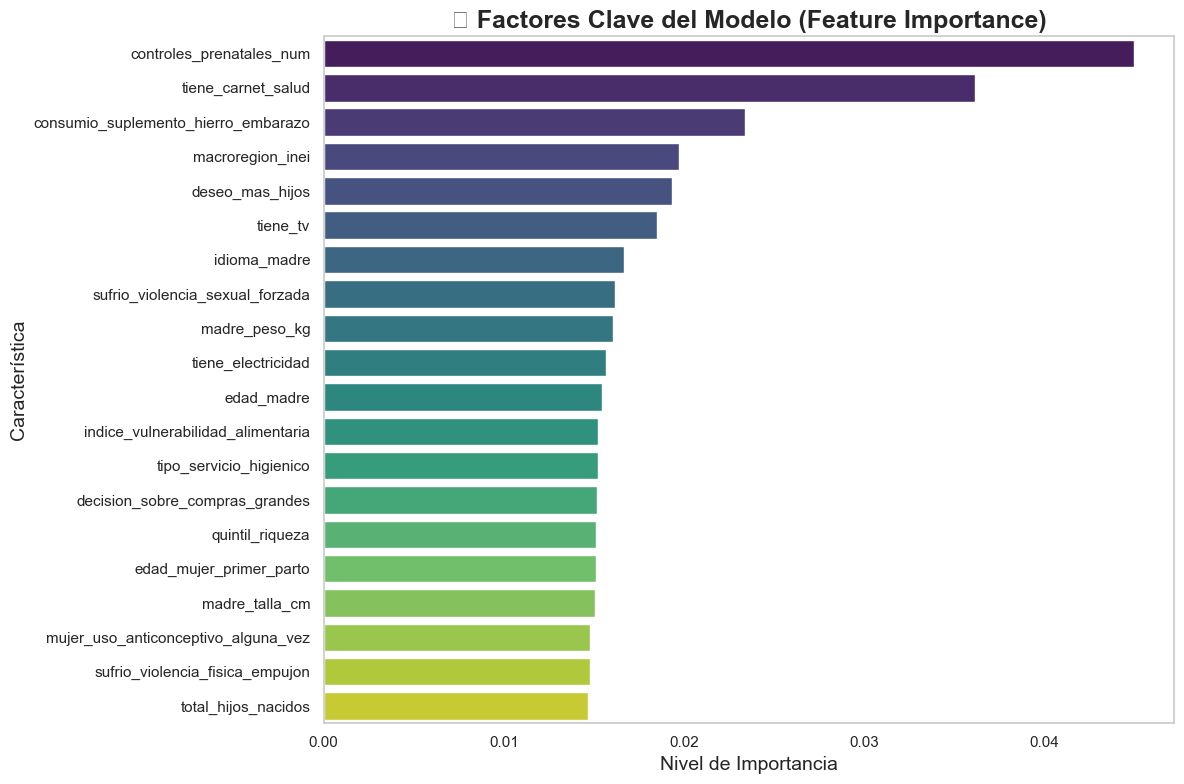

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd # Necesario para el ejemplo

# Asumiendo que 'df_importance' ya existe y tiene las columnas 'feature' e 'importance'
# Ejemplo de df_importance para que el código sea ejecutable:
# df_importance = pd.DataFrame({
#     'feature': [f'feature_{i}' for i in range(15)],
#     'importance': sorted(np.random.rand(15), reverse=True)
# })

print("🎨 Generando el gráfico de Feature Importance...")

# --- Configuración para un solo gráfico ---
sns.set_theme(style="whitegrid", palette="muted")
# Se crea una sola figura y un solo eje (ax)
fig, ax = plt.subplots(figsize=(12, 8))

# --- Gráfico: Feature Importance ---
top_features = df_importance.head(20)
sns.barplot(
    x='importance',
    y='feature',
    data=top_features,
    ax=ax,  # Se dibuja directamente sobre el eje 'ax'
    palette="viridis",
    orient='h'
)

# --- Títulos y Etiquetas ---
ax.set_title("🏆 Factores Clave del Modelo (Feature Importance)", fontsize=18, weight='bold')
ax.set_xlabel("Nivel de Importancia", fontsize=14)
ax.set_ylabel("Característica", fontsize=14)
# Para un gráfico de barras horizontal, la grilla en el eje X es más útil
ax.grid(axis='x')

# Ajusta el layout para que todo encaje bien y muestra el gráfico
plt.tight_layout()
plt.show()